# User preferences
azurill


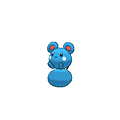

bagon


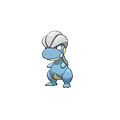

blastoise


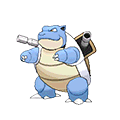

chinchou


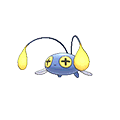

clawitzer


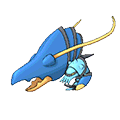

feraligatr


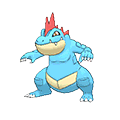

golduck


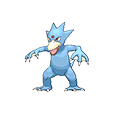

gible


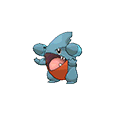

lanturn


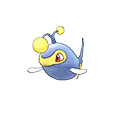

lapras


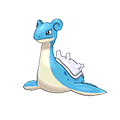

lumineon


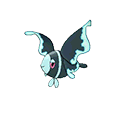

manaphy


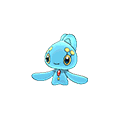

mantyke


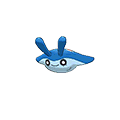

marill


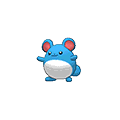

mudkip


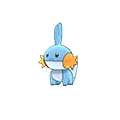

piplup


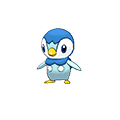

prinplup


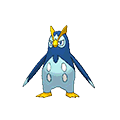

quagsire


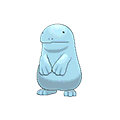

heracross


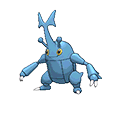

sobble


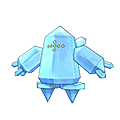

spheal


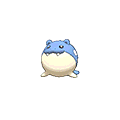

squirtle


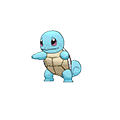

tentacool


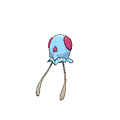

toxicroak


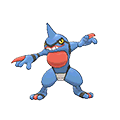

vaporeon


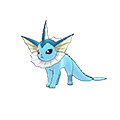

wailord


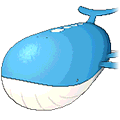

wartortle


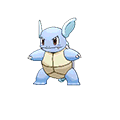

wobbuffet


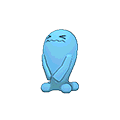

wooper


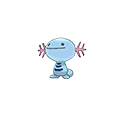

dhelmise


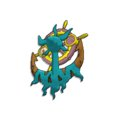

mantine


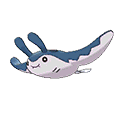

sliggoo


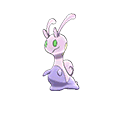

golett


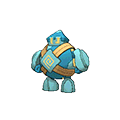

kyogre


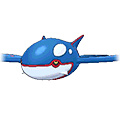

# Predicted as favorites
excadrill


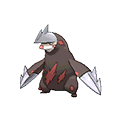

gastly


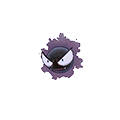

pangoro


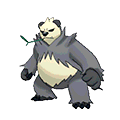

poliwag


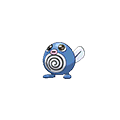

tangrowth


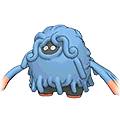

walrein


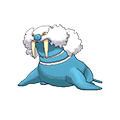

In [7]:
import os
import sys
import json
import math
import numpy
import PIL.Image
from IPython.display import Image, display
from sklearn.cluster import MiniBatchKMeans
from operator import itemgetter


# collect/utils/encoder.py

class ImageEncoder(json.JSONEncoder):
    def default(self, o):
        return o.__dict__

# collect/model/image.py
    
class Image:
    name: str
    colors: list

    def __init__(self, name: str, colors: list):
        self.name = name
        self.colors = colors

    def __str__(self):
        return f"Image(name={self.name}, colors={self.colors})"

# collect/images.py

def is_picture(path: str) -> bool:
    return path.endswith(".png") or path.endswith(".jpg") or path.endswith(".jpeg")

def list_images(path: str) -> list:
    file_list = os.listdir(path)
    filtered_list = filter(is_picture, file_list)
    return list(filtered_list)

def get_image_colors(path: str) -> list:
    n_clusters = 4

    imgfile = PIL.Image.open(path).convert("RGBA")
    numarray = numpy.array(imgfile.getdata(), numpy.uint8)

    clusters = MiniBatchKMeans(n_clusters=n_clusters)
    clusters.fit(numarray)

    npbins = numpy.arange(0, n_clusters + 1)
    histogram = numpy.histogram(clusters.labels_, bins=npbins)

    # Sort histogram
    pairs = sorted(zip(histogram[0], histogram[1]), key=itemgetter(0))
    histogram = (numpy.array([v for v, i in pairs]),
                 numpy.array([i for v, i in pairs]))

    colors = []

    for i in range(n_clusters):
        j = histogram[1][i]

        red = math.ceil(clusters.cluster_centers_[j][0])
        green = math.ceil(clusters.cluster_centers_[j][1])
        blue = math.ceil(clusters.cluster_centers_[j][2])

        rgb = red
        rgb = (rgb << 8) + green
        rgb = (rgb << 8) + blue

        colors.append(rgb)

    return colors

# collect/main.py

data_directory = os.path.join(os.getcwd(), "data")

imageset_path = os.path.join(data_directory, "input", "imageset")
output_path = os.path.join(data_directory, "output", "data.json")

# List images from imageset
image_paths = list_images(imageset_path)
image_list = []

# Get image data from the images
for image_filename in image_paths:
    image_name = os.path.splitext(image_filename)[0]
    image_colors = get_image_colors(
        os.path.join(imageset_path, image_filename))

    image = Image(image_name, image_colors)
    image_list.append(image)

# Store data in a JSON file
with open(output_path, "w") as datafile:
    json_data = json.dumps(image_list, indent=4, cls=ImageEncoder)
    datafile.write(json_data)

    
# exploit/main.py

import pandas
from sklearn.ensemble import RandomForestClassifier

def image_as_cluster(image: dict):
    return (
        image['colors'][0],
        image['colors'][1],
        image['colors'][2],
    )

data_directory = os.path.join(os.getcwd(), "data")

userdata_path = os.path.join(data_directory, 'input', 'user.json')
picturedata_path = os.path.join(data_directory, 'output', 'data.json')

with open(userdata_path) as user_file:
        user_prefs = json.load(user_file)

with open(picturedata_path) as image_file:
        images_data = json.load(image_file)

print("# User preferences")

for name in user_prefs:
    print(name)
    for img_path in image_paths:
        if name in img_path:
            break
    img = PIL.Image.open(os.path.join(imageset_path, img_path))
    display(img)

images = sorted(images_data, key=lambda x: x['name'])
images_as_cluster = [image_as_cluster(image) for image in images]

# Build training data
training_data = images_as_cluster
result_data = [(image['name'] in user_prefs) for image in images]

# Build dataframes
training_df = pandas.DataFrame(training_data, columns=['color1', 'color2', 'color3'])
result_df = pandas.DataFrame(result_data, columns=['favorite'])

# Train decision tree
classifier = RandomForestClassifier(n_estimators=2, max_depth=10)
classifier = classifier.fit(training_df, result_df.values.ravel())

predicted = classifier.predict(list(map(lambda x: x['colors'][:3], images)))

print("# Predicted as favorites")

for index, favorite in enumerate(predicted):
    name = images[index]['name']
    # Only print new images
    if favorite and (name not in user_prefs):
        print(name)
        for img_path in image_paths:
            if name in img_path:
                break
        img = PIL.Image.open(os.path.join(imageset_path, img_path))
        display(img)